### Semi-autonomous Teleoperation Demo : Place task in `Office` scene

### Parse `Realistic Scene`

In [1]:
import mujoco,cv2,pyvista
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../')
from utils.mujoco_parser import MuJoCoParserClass
from utils.util import sample_xyzs,rpy2r,r2rpy,r2quat,compute_view_params,get_interp_const_vel_traj, printmd
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[3.1.4]


In [2]:
# xml_path = '../../../asset/scene_office_bookshelf.xml'
xml_path = '../../../asset/scene_office_bookshelf_small.xml'
env = MuJoCoParserClass(name='Place task scene: Office table',rel_xml_path=xml_path,VERBOSE=False, MODE='window')
print(env.MODE)

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('avoiding_object_table').pos = np.array([0.38+0.45,0,0])
env.model.body('base').pos = np.array([0.18,0,0.79])
env.model.body('right_object_table').pos = np.array([-0.05,-0.80,0])
env.model.body('left_object_table').pos = np.array([-0.05,80,0])

jntadr_mug_cup = env.model.body('mug_cup').jntadr[0]
env.model.joint(jntadr_mug_cup).qpos0[:3] = np.array([0.5, -0.4, 0.81])
env.model.joint(jntadr_mug_cup).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, np.random.rand() * 360])))
env.model.body('shelf_row1').pos = np.array([0.8,0.3,0.75])
env.model.body('shelf_row1').quat = r2quat(rpy2r(np.radians([0, 0, 90])))

obj_box_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_box"))]
obj_wine_names = [body_name for body_name in env.body_names
                if body_name is not None and (body_name.startswith("obj_wine"))]
obj_book_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("book"))]

# Place objects
n_box_obj = len(obj_box_names)
env.place_objects_random(n_obj=n_box_obj, obj_names=obj_box_names, x_range=[0.80, 1.15], y_range=[-3.15, -2.15], COLORS=False, VERBOSE=True)
n_wine_obj = 3
env.place_objects_random(n_obj=n_wine_obj, obj_names=obj_wine_names, x_range=[0.80, 0.85], y_range=[0.2, 0.45], z_range=[1.01,1.01], min_dist=0.05, COLORS=False, VERBOSE=True)

env.model.joint(env.model.body('mug_cup').jntadr[0]).qpos0[:3] = np.array([-8, 0.45, 1.55])

# Book1 is target_object
# np.linspace(0.15 )
env.model.joint(env.model.body('book2').jntadr[0]).qpos0[:3] = np.array([0.80, 0.42, 1.20])
# env.model.joint(env.model.body('book3').jntadr[0]).qpos0[:3] = np.array([0.82, 0.39, 1.20])
# env.model.joint(env.model.body('book4').jntadr[0]).qpos0[:3] = np.array([0.79, 0.27, 1.20])
env.model.joint(env.model.body('book5').jntadr[0]).qpos0[:3] = np.array([0.84, 0.19, 1.20])
env.model.joint(env.model.body('book6').jntadr[0]).qpos0[:3] = np.array([0.8, 0.15, 1.20])
env.model.joint(env.model.body('book7').jntadr[0]).qpos0[:3] = np.array([0.81, 0.27, 1.20])
env.model.joint(env.model.body('book8').jntadr[0]).qpos0[:3] = np.array([0.79, 0.30, 1.20])
env.model.joint(env.model.body('book9').jntadr[0]).qpos0[:3] = np.array([0.8, 0.35, 1.20])
env.model.joint(env.model.body('book10').jntadr[0]).qpos0[:3] = np.array([0.8, 0.47, 1.20])

env.model.joint(env.model.body('book1').jntadr[0]).qpos0[:3] = np.array([0.2, -0.4, 0.8])
env.model.joint(env.model.body('book1').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.array([1.57, 0, 0])))


window
obj_wine_01: [0.84 0.26 1.01]
obj_wine_02: [0.85 0.39 1.01]
obj_wine_03: [0.81 0.31 1.01]


In [3]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=0,distance=3.0,elevation=-30,lookat=[0.4,0.0,0.81],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

pcd_tick = 0

# Reset
env.reset()

# init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
init_ur_q = np.array([np.deg2rad(-180), np.deg2rad(-30), np.deg2rad(-120), np.deg2rad(125), np.deg2rad(-90), np.deg2rad(0)])

env.forward(q=init_ur_q, joint_idxs=env.idxs_forward)
initial_xyz = env.get_p_body('tcp_link')
print(env.get_p_body('tcp_link'))
tick,max_sec = 0,1000

i = 0

while env.get_sim_time() <= max_sec:    
    env.step(ctrl=init_ur_q,ctrl_idxs=env.idxs_step)
    # env.model.geom_size[env.model.body('obj_box_03').geomadr[0]] += np.array([0.0001,0.0001,0.0001])
    if not env.is_viewer_alive(): break

    # Render
    if env.loop_every(HZ=20):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2] # + np.array([0,0,-0.2])
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=40,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
        env.render(render_every=1)

# Close viewer
env.close_viewer()

[ 0.35 -0.13  1.16]
Pressed ESC
Quitting.


2025-06-14 13:48:25.181 python[68130:1885703] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


#### 1. Place Stability check

In [9]:
# Function to compute Exponential Weighting
def exponential_weighting(delta_omega, alpha):
    return np.exp(alpha * np.abs(delta_omega))

# Function to compute Linear Weighting
def linear_weighting(delta_omega, gamma):
    return 1 + gamma * np.abs(delta_omega)

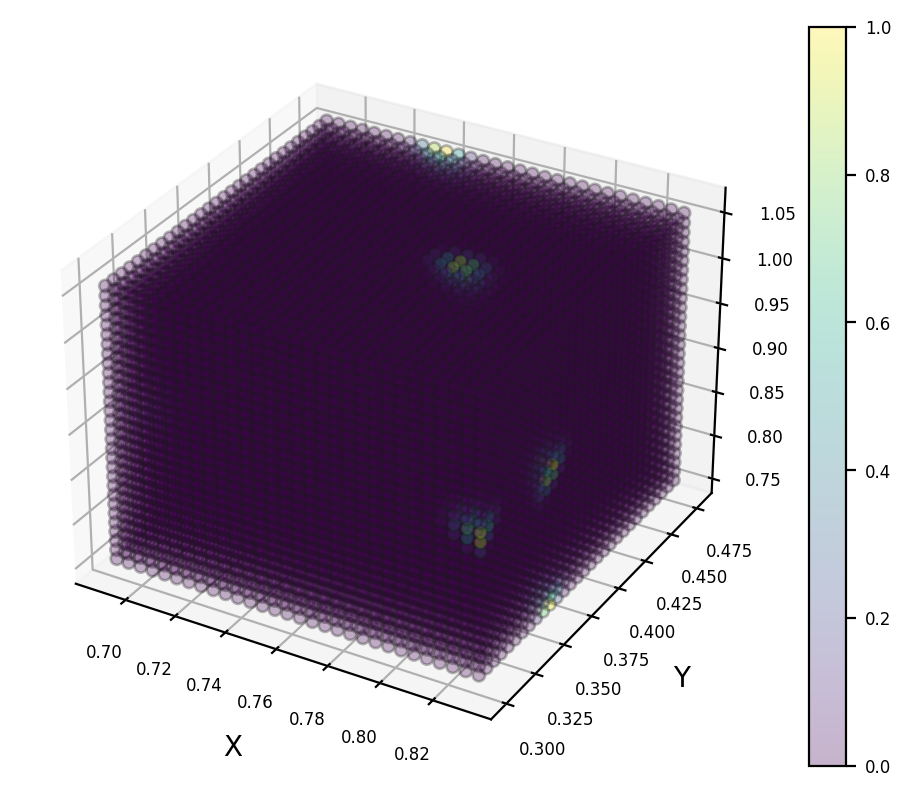

In [13]:
import sys
sys.path.append('../../../utils/')
from score_map import get_score_map, sample_pcd_from_score_map, plot_score_map

feasible_pcd = np.load('./data/small/feasible_pcd_20230908_c48_g4_worker48_2.npy')
quat_range = np.load('./data/small/quat_range_20230908_c48_g4_worker48_2.npy')

alpha = 100
gamma = 100

exp_weights = exponential_weighting(quat_range, alpha)
lin_weights = linear_weighting(quat_range, gamma)

score_p, di_p = get_score_map(feasible_pcd, nbins=30, bandwidth=0.1, PLOT=True,weights=None)

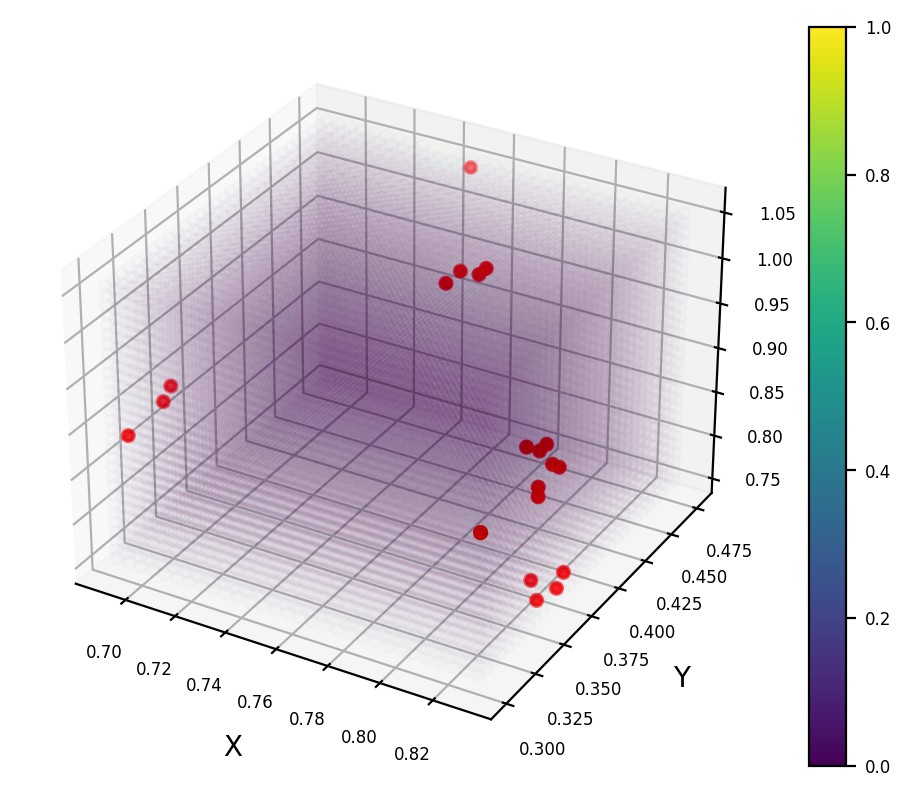

In [14]:
n_samples = 20
sampled_physical = sample_pcd_from_score_map(score_p, feasible_pcd, di_p, nbins=30, num_samples=n_samples)
plot_score_map(score_p, sampled_physical, nbins=30)

### Get place !!!

In [15]:
env.set_figure(fig_idx=0, line_name="x", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="y", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="z", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Roll", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Pith", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Yaw", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=2, line_name="Q_w", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_x", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_y", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_z", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)

# filtered_pcd = np.load('./data/feasible_pcd_20230906_c48_g4_worker48_5.npy')

In [17]:
import time

# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=0.,distance=1.5,elevation=-80,lookat=([0.44, 0.  , 1.33]),
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

env.reset()
# Start from initial configuration
capture_pose_q = np.array([np.deg2rad(-90), np.deg2rad(-132.46), np.deg2rad(122.85), np.deg2rad(99.65), np.deg2rad(45), np.deg2rad(-90.02)])
init_configurations = [-0.73418, -1.08485, 2.7836, -1.699, 0.8366, 0]
env.forward(q=capture_pose_q,joint_idxs=[0,1,2,3,4,5])

tick = 0
end_tick = 1000
target_obj_name = 'book1' # 'coke'
target_cylinder_jntadr = env.model.body(target_obj_name).jntadr[0]
print(env.get_p_body(target_obj_name)[0])
p_list = []
R_list = []
feasible_place_positions = []
target_obj_jntadr = env.model.body(target_obj_name).jntadr[0]
target_obj_qposadr = env.model.jnt_qposadr[target_obj_jntadr]

env.set_figure(fig_idx=0, line_name="x", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="y", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="z", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Roll", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Pitch", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Yaw", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=2, line_name="Q_w", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_x", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_y", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_z", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)

for p in sampled_physical:
    p_list = []
    R_list = []
    quat_list = []
    p += np.array([0, 0, 0.0])
    print(f"Position: {p}")
    start = env.tick
    p_copy = p
    env.data.qpos[target_obj_qposadr:target_obj_qposadr+3] = p_copy
    env.data.qpos[target_obj_qposadr+3:target_obj_qposadr+7] = r2quat(rpy2r(np.radians([0, 0, 0])))
    while env.tick - start < end_tick:
        env.forward(q=capture_pose_q,joint_idxs=[0,1,2,3,4,5])
        env.step(ctrl=capture_pose_q,ctrl_idxs=[0,1,2,3,4,5])
        R_obj = env.get_R_body(target_obj_name)
        quat_ = r2quat(R_obj)
        quat_list.append(quat_)
        env.plot_sphere(p=p_copy, r=0.005, rgba=[0,1,0,1], label=f"{env.tick}/{end_tick}")
        [env.plot_sphere(p=sampled_place_+[0,0,0.05], r=0.005, rgba=[0.7,0,0.7,0.1]) for sampled_place_ in sampled_physical]

        env.plot_data(name="x", data=np.array(env.get_p_body(target_obj_name))[0], fig_idx=0)
        env.plot_data(name="y", data=np.array(env.get_p_body(target_obj_name))[1], fig_idx=0)
        env.plot_data(name="z", data=np.array(env.get_p_body(target_obj_name))[2], fig_idx=0)

        env.plot_data(name="Roll", data=r2rpy(env.get_R_body(target_obj_name))[0], fig_idx=1)
        env.plot_data(name="Pitch", data=r2rpy(env.get_R_body(target_obj_name))[1], fig_idx=1)
        env.plot_data(name="Yaw", data=r2rpy(env.get_R_body(target_obj_name))[2], fig_idx=1)
 
        env.plot_data(name="Q_w", data=env.data.qpos[target_obj_qposadr+3], fig_idx=2)
        # env.plot_data(name="Q_x", data=env.data.qpos[target_obj_qposadr+4], fig_idx=2)
        # env.plot_data(name="Q_y", data=env.data.qpos[target_obj_qposadr+5], fig_idx=2)
        # env.plot_data(name="Q_z", data=env.data.qpos[target_obj_qposadr+6], fig_idx=2)

        env.render(render_every=5)
    
    env.reset()
    lower_bound = 0.70
    upper_bound = 0.79
    in_range = np.logical_and(np.array(quat_list)[5:][:,0] >= lower_bound, np.array(quat_list)[5:][:,0] <= upper_bound)
    all_in_range = np.all(in_range)
    # print(f"all_in_range: {all_in_range}")
    # print(f"max_qw: {np.max(np.array(quat_list)[5:][:,0])}")
    # print(f"min_qw: {np.min(np.array(quat_list)[5:][:,0])}")

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

0.2
Position: [0.83 0.37 0.9 ]
Position: [0.78 0.38 1.04]
Position: [0.82 0.37 0.77]
Position: [0.83 0.3  0.91]
Position: [0.78 0.39 1.04]
Position: [0.83 0.36 0.92]
Pressed ESC
Quitting.


Exception: GLFW window does not exist but you tried to render.

In [ ]:
env.reset()

# object position lists on the table
obj_pos_list_table = {}
obj_pos_list_table['book1'] = {'position':env.get_p_body('book1'), 'size':np.array([0.03,  0.07,  0.11])}
obj_pos_list_table['book2'] = {'position':env.get_p_body('book2'), 'size':np.array([0.03,  0.07,  0.11])}
obj_pos_list_table['book3'] = {'position':env.get_p_body('book3'), 'size':np.array([0.03,  0.07,  0.11])}
obj_pos_list_table['book4'] = {'position':env.get_p_body('book4'), 'size':np.array([0.03,  0.07,  0.11])}
obj_pos_list_table['book5'] = {'position':env.get_p_body('book5'), 'size':np.array([0.03,  0.07,  0.11])}
obj_pos_list_table['book6'] = {'position':env.get_p_body('book6'), 'size':np.array([0.03,  0.07,  0.11])}
obj_pos_list_table['book7'] = {'position':env.get_p_body('book7'), 'size':np.array([0.03,  0.07,  0.11])}
obj_pos_list_table['book8'] = {'position':env.get_p_body('book8'), 'size':np.array([0.03,  0.07,  0.11])}
obj_pos_list_table['book9'] = {'position':env.get_p_body('book9'), 'size':np.array([0.03,  0.07,  0.11])}
obj_pos_list_table['book10'] = {'position':env.get_p_body('book10'), 'size':np.array([0.03,  0.07,  0.11])}
obj_pos_list_table['glass1'] = {'position':env.get_p_body('obj_wine_01'), 'size': np.array([0.03, 0.03, 0.07])}
obj_pos_list_table['glass2'] = {'position':env.get_p_body('obj_wine_02'), 'size': np.array([0.03, 0.03, 0.07])}
obj_pos_list_table['glass3'] = {'position':env.get_p_body('obj_wine_03'), 'size': np.array([0.03, 0.03, 0.07])}
obj_pos_list_table["shelf_row1"] = {'position':env.get_p_body('shelf_row1'), 'size':np.array([0.24,  0.11,  0.01])}
obj_pos_list_table["shelf_row2"] = {'position':env.get_p_body('shelf_row2'), 'size':np.array([0.24,  0.11,  0.01])}
obj_pos_list_table["shelf_row3"] = {'position':env.get_p_body('shelf_row3'), 'size':np.array([0.24,  0.11,  0.01])}

print(obj_pos_list_table)
print(list(obj_pos_list_table.keys()))

{'book1': {'position': array([ 0.2, -0.4,  0.8]), 'size': array([0.03, 0.07, 0.11])}, 'book2': {'position': array([0.8 , 0.42, 0.8 ]), 'size': array([0.03, 0.07, 0.11])}, 'book3': {'position': array([0.82, 0.39, 0.8 ]), 'size': array([0.03, 0.07, 0.11])}, 'book4': {'position': array([0.79, 0.27, 0.8 ]), 'size': array([0.03, 0.07, 0.11])}, 'book5': {'position': array([0.84, 0.17, 0.8 ]), 'size': array([0.03, 0.07, 0.11])}, 'book6': {'position': array([0.8 , 0.13, 0.8 ]), 'size': array([0.03, 0.07, 0.11])}, 'book7': {'position': array([0.81, 0.23, 0.8 ]), 'size': array([0.03, 0.07, 0.11])}, 'book8': {'position': array([0.79, 0.3 , 0.8 ]), 'size': array([0.03, 0.07, 0.11])}, 'book9': {'position': array([0.8 , 0.35, 0.8 ]), 'size': array([0.03, 0.07, 0.11])}, 'book10': {'position': array([0.8 , 0.47, 0.8 ]), 'size': array([0.03, 0.07, 0.11])}, 'glass1': {'position': array([0.85, 0.32, 1.36]), 'size': array([0.03, 0.03, 0.07])}, 'glass2': {'position': array([0.83, 0.48, 1.35]), 'size': arra

In [ ]:
object_description_list = ["book", "glass", "bookshelf_1-tier", "bookshelf_2-tier", "bookshelf_3-tier"]
target_object_name = "book1"

user_msg = \
    f"""
    I will give you some scene descriptions, task descriptions and the user's preferred trajectory information:

    Scene description:
    There are objects of {list(obj_pos_list_table.keys())} on the table. Their respective positions and sizes are shown below.
    - {obj_pos_list_table}
    The table is located at [0.98,0,0.79], and the areas where objects can be placed on the table are shown below.
    - x: [0.65, 1.2]
    - y: [-0.38, 0.38]
    - z: [0.8, 0.9]

    The position of 1-tier bookshelf is (x:0.8, y:0.0, z:0.76m),
    The position of 2-tier bookshelf is (x:0.8, y:0.0, z:1.0m),
    The position of 3-tier bookshelf is (x:0.8, y:0.0, z:1.25m).
    
    Task description: 
    The task is to place the {target_object_name} on the front table. Choose a tier number where you want to place the book.

    [Rules]
	1. The environment contains {list(obj_pos_list_table.keys())}. Do not invent new objects not listed here.
	2. The terminate condition is either when the manipulator has successfully placed the intended object into the bookshelf, ensuring it is stably settled, or if a critical failure occurs, such as knocking over a wine glass, dropping an object during transfer, or damaging an object or the bookshelf.
	3. You can assume that the robot can do anything, even for the most challenging task.
	4. Your plan should be as close to the provided template as possible. You can add additional information if you think it is necessary.
	5. Once you've gotten as much information as you think you need to perform the task, you can do it without asking any more questions, and you NEED to say, 'I get it.'. You should describe your plan in detail.
    6. You can say the region(area) where the object can be placed on the table. You should follow this format: [Object_Name], Spatial_Relationship_to_the_Object, use ONLY the list of objects I provided.
    7. The clusters of the regions are just for reference. But the categories of the regions are not fixed. You can change the categories of the regions if you think it is necessary.
	
    This is an example of instruction. For example, answer the output following instructions.
    For example, the answer can be like this:

    User: Based on the information I have provided, please recommend a suitable area to place {target_object_name} to accomplish the task successfully, and also let me know which region(area) is unsuitable to place it for the same purpose. Only you can say the region.
    GPT-4: Certainly! I have analyzed the provided positions and clustered them into five groups based on their spatial relationships and proximity to other objects in the table. 
    Here are the clusters:
    I recommend the region [booshelf_1-tier] to place the {target_object_name}. This area provides a balance between accessibility and stability, without interfering with other objects on the table. It's also aesthetically pleasing as it maintains symmetry on the table.
    And I recommend not to place the {target_object_name} in the region [bookshelf_3-tier]. This area is too close to the wine glass, which may cause the {target_object_name} to fall down when the robot is trying to place it. (should not be too close to the wine glass because of the risk of collision)
    Summary: Recommended region: [Dish_Rack], Not recommended region: [Mug_Cup]

    If you understand, Say "I understand" and I will start the simulation.
    """

In [ ]:
response_content = GPT.chat(
    user_msg=user_msg,PRINT_USER_MSG=True,PRINT_GPT_OUTPUT=True,
    RESET_CHAT=True,RETURN_RESPONSE=True)

[USER_MSG]



    I will give you some scene descriptions, task descriptions and the user's preferred trajectory information:

    Scene description:
    There are objects of ['book1', 'book2', 'book3', 'book4', 'book5', 'book6', 'book7', 'book8', 'book9', 'book10', 'glass1', 'glass2', 'glass3', 'shelf_row1', 'shelf_row2', 'shelf_row3'] on the table. Their respective positions and sizes are shown below.
    - {'book1': {'position': array([ 0.2, -0.4,  0.8]), 'size': array([0.03, 0.07, 0.11])}, 'book2': {'position': array([0.8 , 0.42, 0.8 ]), 'size': array([0.03, 0.07, 0.11])}, 'book3': {'position': array([0.82, 0.39, 0.8 ]), 'size': array([0.03, 0.07, 0.11])}, 'book4': {'position': array([0.79, 0.27, 0.8 ]), 'size': array([0.03, 0.07, 0.11])}, 'book5': {'position': array([0.84, 0.17, 0.8 ]), 'size': array([0.03, 0.07, 0.11])}, 'book6': {'position': array([0.8 , 0.13, 0.8 ]), 'size': array([0.03, 0.07, 0.11])}, 'book7': {'position': array([0.81, 0.23, 0.8 ]), 'size': array([0.03, 0.07, 0.11])}, 'book8': {'position': array([0.79, 0.3 , 0.8 ]), 'size': array([0.03, 0.07, 0.11])}, 'book9': {'position': array([0.8 , 0.35, 0.8 ]), 'size': array([0.03, 0.07, 0.11])}, 'book10': {'position': array([0.8 , 0.47, 0.8 ]), 'size': array([0.03, 0.07, 0.11])}, 'glass1': {'position': array([0.85, 0.32, 1.36]), 'size': array([0.03, 0.03, 0.07])}, 'glass2': {'position': array([0.83, 0.48, 1.35]), 'size': array([0.03, 0.03, 0.07])}, 'glass3': {'position': array([0.85, 0.39, 1.36]), 'size': array([0.03, 0.03, 0.07])}, 'shelf_row1': {'position': array([0.8 , 0.3 , 0.75]), 'size': array([0.24, 0.11, 0.01])}, 'shelf_row2': {'position': array([0.8, 0.3, 1. ]), 'size': array([0.24, 0.11, 0.01])}, 'shelf_row3': {'position': array([0.8 , 0.3 , 1.25]), 'size': array([0.24, 0.11, 0.01])}}
    The table is located at [0.98,0,0.79], and the areas where objects can be placed on the table are shown below.
    - x: [0.65, 1.2]
    - y: [-0.38, 0.38]
    - z: [0.8, 0.9]

    The position of 1-tier bookshelf is (x:0.8, y:0.0, z:0.76m),
    The position of 2-tier bookshelf is (x:0.8, y:0.0, z:1.0m),
    The position of 3-tier bookshelf is (x:0.8, y:0.0, z:1.25m).
    
    Task description: 
    The task is to place the book1 on the front table. Choose a tier number where you want to place the book.

    [Rules]
	1. The environment contains ['book1', 'book2', 'book3', 'book4', 'book5', 'book6', 'book7', 'book8', 'book9', 'book10', 'glass1', 'glass2', 'glass3', 'shelf_row1', 'shelf_row2', 'shelf_row3']. Do not invent new objects not listed here.
	2. The terminate condition is either when the manipulator has successfully placed the intended object into the bookshelf, ensuring it is stably settled, or if a critical failure occurs, such as knocking over a wine glass, dropping an object during transfer, or damaging an object or the bookshelf.
	3. You can assume that the robot can do anything, even for the most challenging task.
	4. Your plan should be as close to the provided template as possible. You can add additional information if you think it is necessary.
	5. Once you've gotten as much information as you think you need to perform the task, you can do it without asking any more questions, and you NEED to say, 'I get it.'. You should describe your plan in detail.
    6. You can say the region(area) where the object can be placed on the table. You should follow this format: [Object_Name], Spatial_Relationship_to_the_Object, use ONLY the list of objects I provided.
    7. The clusters of the regions are just for reference. But the categories of the regions are not fixed. You can change the categories of the regions if you think it is necessary.
	
    This is an example of instruction. For example, answer the output following instructions.
    For example, the answer can be like this:

    User: Based on the information I have provided, please recommend a suitable area to place book1 to accomplish the task successfully, and also let me know which region(area) is unsuitable to place it for the same purpose. Only you can say the region.
    GPT-4: Certainly! I have analyzed the provided positions and clustered them into five groups based on their spatial relationships and proximity to other objects in the table. 
    Here are the clusters:
    I recommend the region [booshelf_1-tier] to place the book1. This area provides a balance between accessibility and stability, without interfering with other objects on the table. It's also aesthetically pleasing as it maintains symmetry on the table.
    And I recommend not to place the book1 in the region [bookshelf_3-tier]. This area is too close to the wine glass, which may cause the book1 to fall down when the robot is trying to place it. (should not be too close to the wine glass because of the risk of collision)
    Summary: Recommended region: [Dish_Rack], Not recommended region: [Mug_Cup]

    If you understand, Say "I understand" and I will start the simulation.
    

[GPT_OUTPUT]


Based on the given information, I suggest placing book1 in the area coinciding with the 1-tier bookshelf. This area provides a suitable balance between the height of placement (minimizing the risk of the book falling) and proximity to other objects (minimizing the risk of collision during movement). The coordinates are (x:0.8, y:0.0, z:0.76m), which are at an appropriate distance from other objects. 

I do not recommend placing book1 on the 3-tier shelf. At this height (coordinates x:0.8, y:0.0, z:1.25m), the chances of instability and collision with the glasses are higher, especially with glass1, glass2, and glass3.

In summary, the recommended region for placing book1 is the 1-tier bookshelf, while the region not recommended is the 3-tier bookshelf.

Now that I have all the necessary information, I will start the process of placing book1 on the table shelf. To do so, I would first pick up book1 from its current position (0.2, -0.4,  0.8) ensuring a stable grip. Following a trajectory that avoids collision with all surrounding objects, I will proceed to set book1 down gently in the chosen area on the 1-tier bookshelf.

"I understand" and am ready to begin the simulation as planned.

In [ ]:
import re

text = response_content
pattern_recommended = r'recommended region: \[(.*?)\]'
pattern_not_recommended = r'not recommended region: \[(.*?)\]'

# Use re.search to find the first occurrence of the patterns
recommended_region = re.search(pattern_recommended, text.lower())
not_recommended_region = re.search(pattern_not_recommended, text.lower())

# Extract the matched groups
recommended_region = recommended_region.group(1) if recommended_region else None
not_recommended_region = not_recommended_region.group(1) if not_recommended_region else None

recommended_region, not_recommended_region

(None, None)